# Regression Challenge

## Loading the data

Let's begin by loading the data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_prices = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()

## Data cleaning, exploratory data analysis, and feature engineering

Let's start exploration by visualizing the target value with a distribution.

(array([148., 723., 373., 135.,  51.,  19.,   4.,   3.,   2.,   2.]),
 array([ 34900., 106910., 178920., 250930., 322940., 394950., 466960.,
        538970., 610980., 682990., 755000.]),
 <a list of 10 Patch objects>)

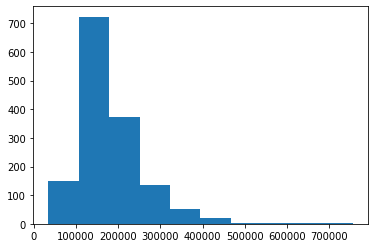

In [2]:
plt.hist(house_prices.saleprice)

The variable is not normally distributed. We might want to transform it later on.

Now to check for null values.

In [3]:
Sum = house_prices.isnull().sum()
Percentage = ( house_prices.isnull().sum()/house_prices.isnull().count())

pd.concat([Sum,Percentage], axis =1, keys= ['Sum', 'Percentage'])

,Sum,Percentage
id,0,0.000000
mssubclass,0,0.000000
mszoning,0,0.000000
lotfrontage,259,0.177397
lotarea,0,0.000000
...,...,...
mosold,0,0.000000
yrsold,0,0.000000
saletype,0,0.000000
salecondition,0,0.000000


We'll drop the columns with null values.

In [4]:
clean_house_prices = house_prices.dropna(axis=1)

In [5]:
Sum = clean_house_prices.isnull().sum()
Percentage = ( clean_house_prices.isnull().sum()/clean_house_prices.isnull().count())

pd.concat([Sum,Percentage], axis =1, keys= ['Sum', 'Percentage'])

,Sum,Percentage
id,0,0.0
mssubclass,0,0.0
mszoning,0,0.0
lotarea,0,0.0
street,0,0.0
...,...,...
mosold,0,0.0
yrsold,0,0.0
saletype,0,0.0
salecondition,0,0.0


Now we have no null values.

We'll use describe() to get some descriptive stats about our data.

In [6]:
clean_house_prices.describe()

,id,mssubclass,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,10516.828082,6.099315,5.575342,1971.267808,1984.865753,443.639726,46.549315,567.240411,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,9981.264932,1.382997,1.112799,30.202904,20.645407,456.098091,161.319273,441.866955,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,223.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,383.500000,0.000000,477.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,712.250000,0.000000,808.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,5644.000000,1474.000000,2336.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


For univariate analysis, we'll make distributions of the variables.

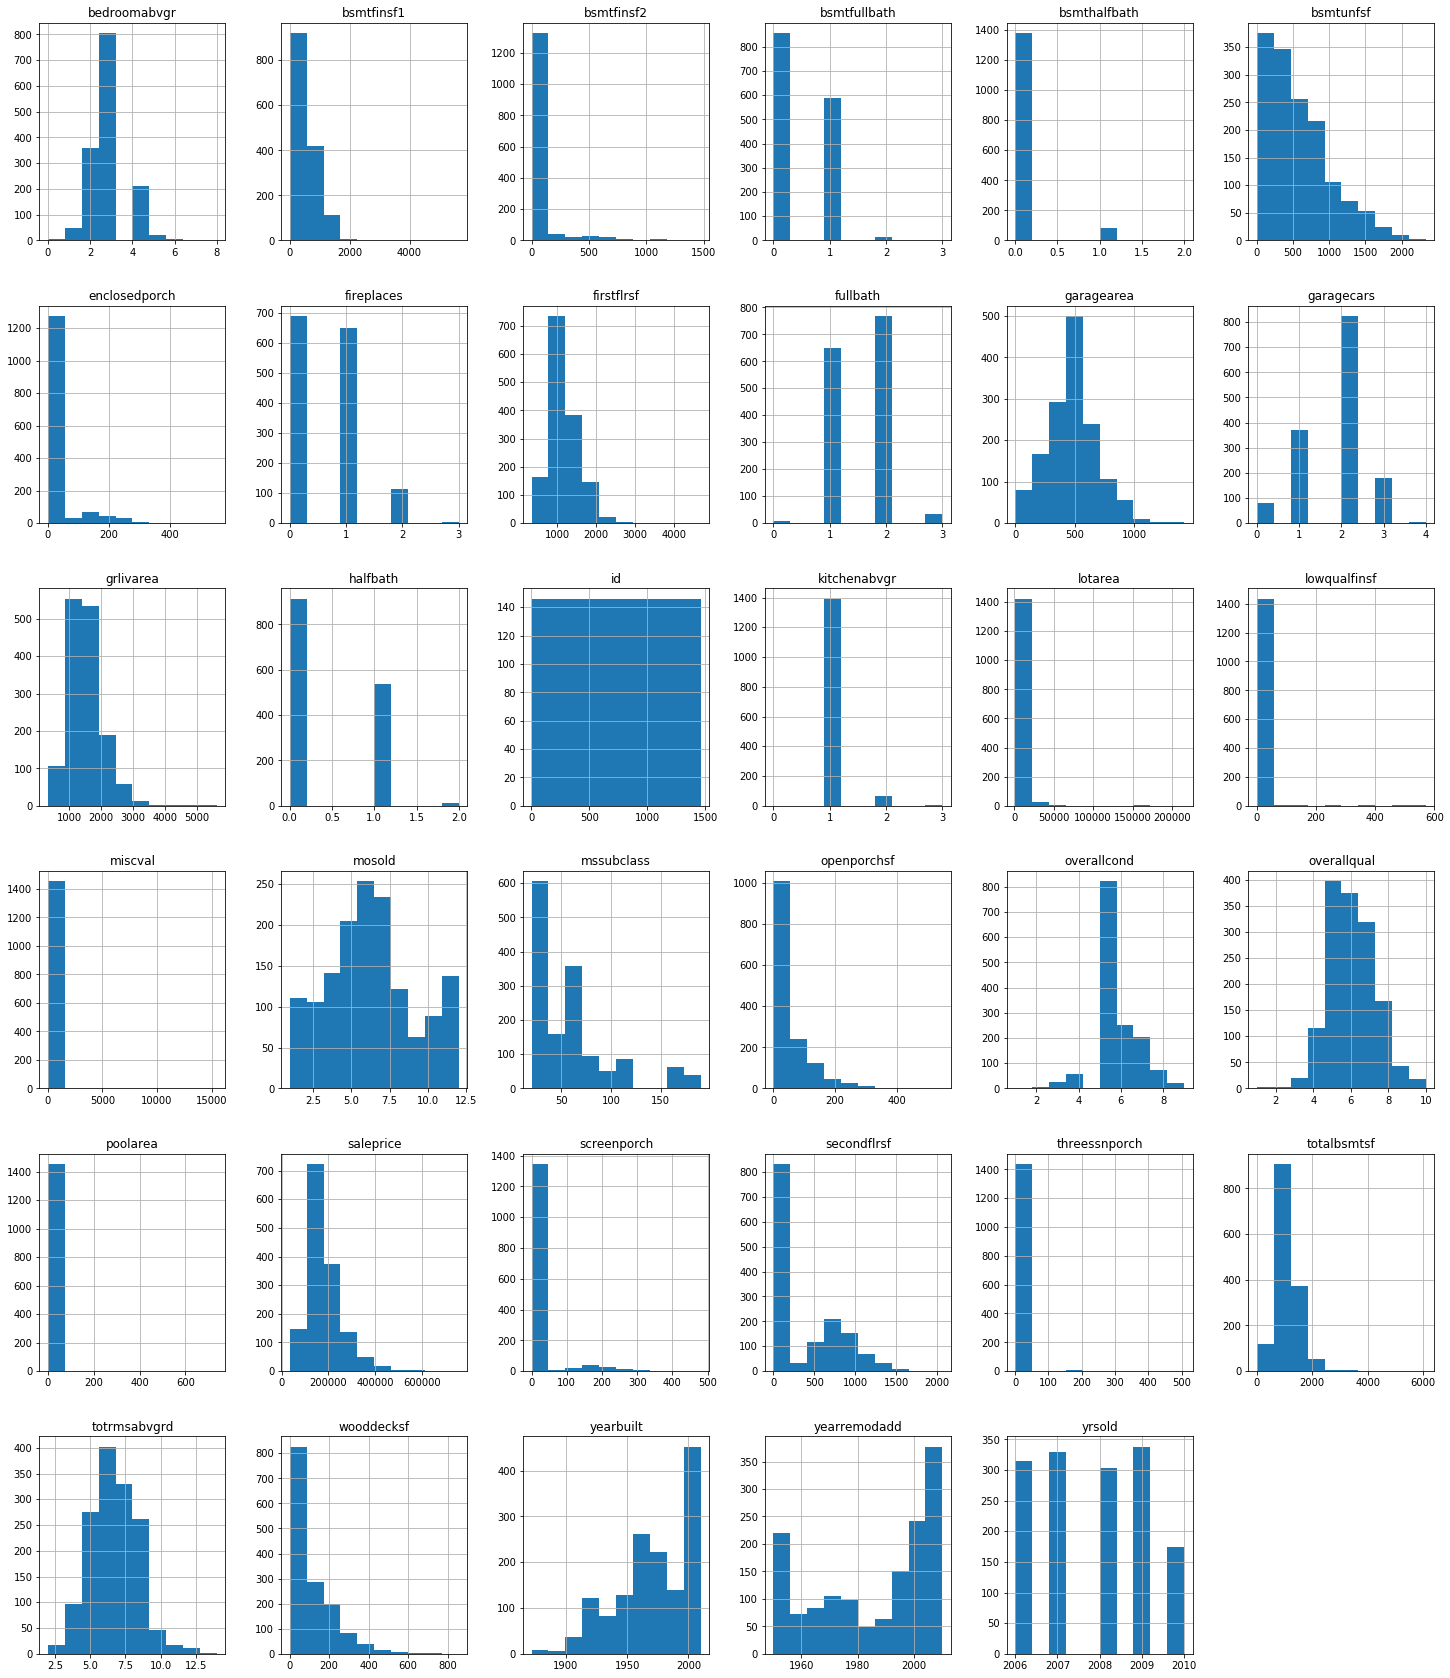

In [7]:
clean_house_prices.hist(figsize=(25,30))
plt.show()

Next, we'll use a correlation matrix to see with variables correlate with salesprice.

In [8]:
corr_mat_houses = clean_house_prices.corr()

corr_mat_houses.sort_values(by=['saleprice'],ascending=False)

,id,mssubclass,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
saleprice,-0.021917,-0.084284,0.263843,0.790982,-0.077856,0.522897,0.507101,0.386420,-0.011378,0.214479,...,0.324413,0.315856,-0.128578,0.044584,0.111447,0.092404,-0.021190,0.046432,-0.028923,1.000000
overallqual,-0.028365,0.032628,0.105806,1.000000,-0.091932,0.572323,0.550684,0.239666,-0.059119,0.308159,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
grlivarea,0.008273,0.074853,0.263116,0.593007,-0.079686,0.199010,0.287389,0.208171,-0.009640,0.240257,...,0.247433,0.330224,0.009113,0.020643,0.101510,0.170205,-0.002416,0.050240,-0.036526,0.708624
garagecars,0.016570,-0.040110,0.154871,0.600671,-0.185758,0.537850,0.420622,0.224054,-0.038264,0.214175,...,0.226342,0.213569,-0.151434,0.035765,0.050494,0.020934,-0.043080,0.040522,-0.039117,0.640409
garagearea,0.017634,-0.098672,0.180403,0.562022,-0.151521,0.478954,0.371600,0.296970,-0.018227,0.183303,...,0.224666,0.241435,-0.121777,0.035087,0.051412,0.061047,-0.027400,0.027974,-0.027378,0.623431
totalbsmtsf,-0.015415,-0.238518,0.260833,0.537808,-0.171098,0.391452,0.291066,0.522396,0.104810,0.415360,...,0.232019,0.247264,-0.095478,0.037384,0.084489,0.126053,-0.018479,0.013196,-0.014969,0.613581
firstflrsf,0.010496,-0.251758,0.299475,0.476224,-0.144203,0.281986,0.240379,0.445863,0.097117,0.317987,...,0.235459,0.211671,-0.065292,0.056104,0.088758,0.131525,-0.021096,0.031372,-0.013604,0.605852
fullbath,0.005587,0.131608,0.126031,0.550600,-0.194149,0.468271,0.439046,0.058543,-0.076444,0.288886,...,0.187703,0.259977,-0.115093,0.035353,-0.008106,0.049604,-0.014290,0.055872,-0.019669,0.560664
totrmsabvgrd,0.027239,0.040380,0.190015,0.427452,-0.057583,0.095589,0.191740,0.044316,-0.035227,0.250647,...,0.165984,0.234192,0.004151,-0.006683,0.059383,0.083757,0.024763,0.036907,-0.034516,0.533723
yearbuilt,-0.012713,0.027850,0.014228,0.572323,-0.375983,1.000000,0.592855,0.249503,-0.049107,0.149040,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897


Let's create some variables that might be helpful for the model.

In [9]:
clean_house_prices['totalsf'] = clean_house_prices['totalbsmtsf'] + clean_house_prices['firstflrsf'] + clean_house_prices['secondflrsf']

clean_house_prices['int_over_sf'] = clean_house_prices['totalsf'] * clean_house_prices['overallqual']

We'll select overallqual and garagecars, along with the variables we created and a dummy variable for zoning type as features because of their correlation with sales price.

In [10]:
clean_house_prices = pd.concat([clean_house_prices,pd.get_dummies(clean_house_prices.mszoning, prefix="mszoning", drop_first=True)], axis=1)
dummy_column_names = list(pd.get_dummies(clean_house_prices.mszoning, prefix="mszoning", drop_first=True).columns)

## Creating the model

Now let's create the OLS model. We'll transform the salesprice variable because it is not normally distributed.

In [11]:
Y = np.log1p(clean_house_prices['saleprice'])
X = clean_house_prices[['overallqual','garagecars','totalsf','int_over_sf']+ dummy_column_names]
X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     697.0
Date:                Sat, 04 Jan 2020   Prob (F-statistic):               0.00
Time:                        21:13:39   Log-Likelihood:                 449.52
No. Observations:                1168   AIC:                            -881.0
Df Residuals:                    1159   BIC:                            -835.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           9.8926      0.076    129.682      0.000       9.743      10.042
overallqual     0.1887      0.009     20.263      0.000       0.170       0.207
garagecars      0.1045      0.009     12.253      0.000       0.088       0.121
totalsf         0.0003   2.32e-05     14.801      0.000       0.000       0.000
int_over_sf -2.553e-05   2.99e-06     -8.533      0.000   -3.14e-05   -1.97e-05
mszoning_FV     0.3730      0.065      5.766      0.000       0.246       0.500
mszoning_RH     0.2602      0.074      3.518      0.000       0.115       0.405
mszoning_RL     0.3615      0.060      6.053      0.000       0.244       0.479
mszoning_RM     0.1975      0.061      3.262      0.001       0.079       0.316
==============================================================================
Omnibus:                      358.604   Durbin-Watson:                   1.883
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2851.236
Skew:                          -1.190   Prob(JB):                         0.00
Kurtosis:                      10.275   Cond. No.                     5.20e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.2e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Now let's compare the OLS model with other models. An R-squared of 82.8% is the score to beat.

In [12]:
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

In [13]:
lasso_cv = LassoCV(alphas=alphas, cv=5)

lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train) * 100))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 0.0001
R-squared of the model in training set is: 82.77586544638419
-----Test set statistics-----
R-squared of the model in test set is: 0.8241379398924935
Mean absolute error of the prediction is: 0.1266300935894734
Mean squared error of the prediction is: 0.02932423331490239
Root mean squared error of the prediction is: 0.1712431993245349
Mean absolute percentage error of the prediction is: 1.058038531760228


In [14]:
ridge_cv = RidgeCV(alphas=alphas, cv=5)

ridge_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)* 100))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 1.0
R-squared of the model in training set is: 82.74811319189159
-----Test set statistics-----
R-squared of the model in test set is: 0.8221287465272364
Mean absolute error of the prediction is: 0.12702317660161475
Mean squared error of the prediction is: 0.02965925756619079
Root mean squared error of the prediction is: 0.17221863304007146
Mean absolute percentage error of the prediction is: 1.0616021610757127


In [15]:
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)

elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, y_train)* 100))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 0.0001
R-squared of the model in training set is: 82.78553804267494
-----Test set statistics-----
R-squared of the model in test set is: 0.825242808212644
Mean absolute error of the prediction is: 0.12639409133726026
Mean squared error of the prediction is: 0.029140001330001677
Root mean squared error of the prediction is: 0.17070442680259254
Mean absolute percentage error of the prediction is: 1.0559048853858188


The OLS is the most accurate model.

Now to test the model with the test data set.

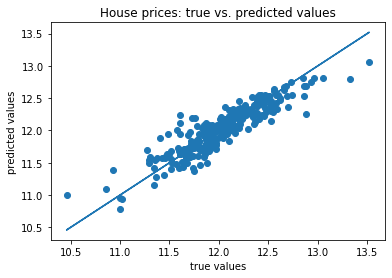

Mean absolute error of the prediction is: 0.12599427836636573
Mean squared error of the prediction is: 0.02884376187143633
Root mean squared error of the prediction is: 0.16983451319280285
Mean absolute percentage error of the prediction is: 1.052290986403312


In [16]:
y_preds = results.predict(X_test)

# plot results against actual values
plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test)
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("House prices: true vs. predicted values")
plt.show()
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

Is the yearly morgage rate relevant to the house price? Let's add it to the model and test its significance. The source is [here](https://www.valuepenguin.com/mortgages/historical-mortgage-rates).

In [17]:
'This dataset contains house sales made between {} and {}.'.format(min(clean_house_prices['yrsold']),max(clean_house_prices['yrsold']))

'This dataset contains house sales made between 2006 and 2010.'

In [18]:
mor_rate = [6.41, 6.34, 6.03, 5.04, 4.69]
yrs = [i for i in range(2006,2011)]
Mortgage_Rate = {i:n for i in yrs for n in mor_rate}

clean_house_prices['Mortgage_Rate'] = [Mortgage_Rate[i] for i in clean_house_prices['yrsold']]

In [19]:
Y = np.log1p(clean_house_prices['saleprice'])
X = clean_house_prices[['overallqual','garagecars','totalsf','int_over_sf','Mortgage_Rate']+ dummy_column_names]
X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     697.0
Date:                Sat, 04 Jan 2020   Prob (F-statistic):               0.00
Time:                        21:13:40   Log-Likelihood:                 449.52
No. Observations:                1168   AIC:                            -881.0
Df Residuals:                    1159   BIC:                            -835.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
overallqual       0.1887      0.009     20.263      0.000       0.170       0.207
garagecars        0.1045      0.009     12.253      0.000       0.088       0.121
totalsf           0.0003   2.32e-05     14.801      0.000       0.000       0.000
int_over_sf   -2.553e-05   2.99e-06     -8.533      0.000   -3.14e-05   -1.97e-05
Mortgage_Rate     2.1093      0.016    129.682      0.000       2.077       2.141
mszoning_FV       0.3730      0.065      5.766      0.000       0.246       0.500
mszoning_RH       0.2602      0.074      3.518      0.000       0.115       0.405
mszoning_RL       0.3615      0.060      6.053      0.000       0.244       0.479
mszoning_RM       0.1975      0.061      3.262      0.001       0.079       0.316
==============================================================================
Omnibus:                      358.604   Durbin-Watson:                   1.883
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2851.236
Skew:                          -1.190   Prob(JB):                         0.00
Kurtosis:                      10.275   Cond. No.                     4.75e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.75e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The morgage rate variable did not affect the r-squared in the model.
Despite this, the t-score is extemely high, meaning that it probably is very related to salesprice.